## **Sentiment Analysis** of the **Restaurant Reviews** from **YELP** dataset

###  An example of a **pretrained word embeddings**: **Glove**

#### Import libraries

In [1]:
import warnings
from zeugma.embeddings import EmbeddingTransformer
import pandas as pd
import numpy as np
import tensorflow as tf
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn import metrics
from sklearn.metrics import plot_confusion_matrix
from sklearn.metrics import accuracy_score,f1_score,precision_score, recall_score, confusion_matrix
from sklearn.model_selection import GridSearchCV
from sklearn import svm
from sklearn.linear_model import LogisticRegression
import sys
import os


In [2]:
if not sys.warnoptions:
    warnings.simplefilter("ignore")
    os.environ["PYTHONWARNINGS"] = "ignore" 

#### Read the dataset from the GCP **bucket**

In [3]:
df = pd.read_csv('gs://demo2222/df_final.csv')

#### Train/test split **keeping** the two **columns of interest** and **preserve** the **same proportions** of examples in **each class** as **observed** in the **original dataset**

In [4]:
X = df['cleaned_reviews'] 
y = df['sentiment']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, random_state = 42, stratify=y)

#### UDF for **evaluating** models

In [5]:
def evaluate(y_test, predictions):
    cf_matrix = confusion_matrix(y_test, predictions)
    sns.heatmap(cf_matrix, annot = True, fmt = 'd',cmap="Blues")
    plt.title('Heatmap of confusion matrix for Test data')
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

In [6]:
corpus_train = X_train
corpus_test = X_test

### **glove-twitter-200**: pre-trained **glove vectors** based on 2B tweets, 27B tokens, 1.2M vocab, **uncased**

In [7]:
glove_twitter = EmbeddingTransformer('glove-twitter-200') 

In [8]:
x_train_twitter = glove_twitter.transform(corpus_train) 
x_test_twitter = glove_twitter.transform(corpus_test) 

#### Using **Logistic Regression** model with the **default hyperparameters**

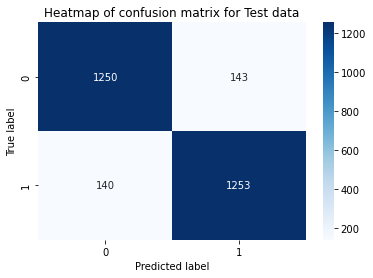

In [9]:
model_lr = LogisticRegression(random_state=42)
model_lr.fit(x_train_twitter, y_train)
predictions = model_lr.predict(x_test_twitter)
evaluate(y_test, predictions)

In [10]:
from sklearn.metrics import classification_report
print(classification_report(y_test, predictions, digits=4))

              precision    recall  f1-score   support

         0.0     0.8993    0.8973    0.8983      1393
         1.0     0.8976    0.8995    0.8985      1393

    accuracy                         0.8984      2786
   macro avg     0.8984    0.8984    0.8984      2786
weighted avg     0.8984    0.8984    0.8984      2786



#### Using **SVM** model with the **default hyperparameters**

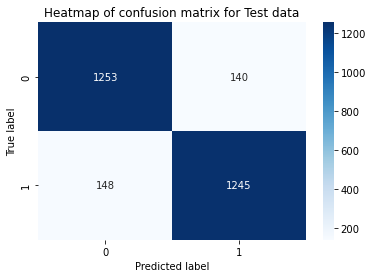

In [11]:
model_svm = svm.SVC(random_state=42)
model_svm.fit(x_train_twitter, y_train)
predictions = model_svm.predict(x_test_twitter)
evaluate(y_test, predictions)

In [12]:
print(classification_report(y_test, predictions, digits=4))

              precision    recall  f1-score   support

         0.0     0.8944    0.8995    0.8969      1393
         1.0     0.8989    0.8938    0.8963      1393

    accuracy                         0.8966      2786
   macro avg     0.8966    0.8966    0.8966      2786
weighted avg     0.8966    0.8966    0.8966      2786



#### Using **Logistic Regression** model with **hyperparameter tuning** (1,000 iterations to achieve convergence)

Best l1_ratio: 0.1
Best C: 3
Best penalty: elasticnet
Best solver: saga


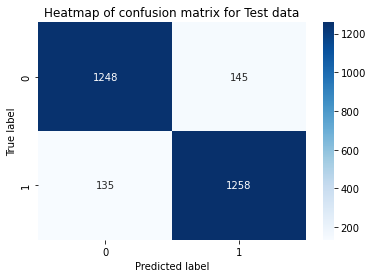

In [13]:
grid_lr = {"C":[1, 3, 5, 7], 'l1_ratio':['none', 0, 0.1, 0.3, 0.5], 'penalty':['l2', 'elasticnet'],
       'solver':['lbfgs', 'saga']}

model_lr_1000 = LogisticRegression(max_iter=1000, random_state=42)

logreg_cv_twitter=GridSearchCV(model_lr_1000, grid_lr, scoring='f1', cv=2)
logreg_cv_twitter.fit(x_train_twitter, y_train)

print('Best l1_ratio:', logreg_cv_twitter.best_estimator_.get_params()['l1_ratio'])
print('Best C:', logreg_cv_twitter.best_estimator_.get_params()['C'])
print('Best penalty:', logreg_cv_twitter.best_estimator_.get_params()['penalty'])
print('Best solver:', logreg_cv_twitter.best_estimator_.get_params()['solver'])

predictions = logreg_cv_twitter.predict(x_test_twitter)
evaluate(y_test, predictions )

In [14]:
print(classification_report(y_test, predictions, digits=4))

              precision    recall  f1-score   support

         0.0     0.9024    0.8959    0.8991      1393
         1.0     0.8967    0.9031    0.8999      1393

    accuracy                         0.8995      2786
   macro avg     0.8995    0.8995    0.8995      2786
weighted avg     0.8995    0.8995    0.8995      2786



#### Using **SVM** model with **hyperparameter tuning**

Best KERNEL: rbf
Best C: 140


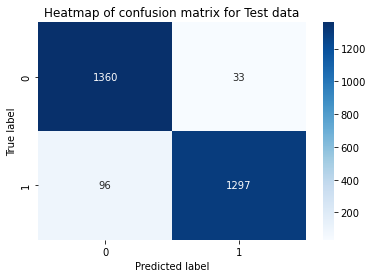

In [15]:
grid_svm = [
    {'kernel':('linear', 'rbf')},
    {'C':[1, 40, 80, 120, 140, 160]},
]    

model_svm = svm.SVC(random_state=42)


svm_model_cv_twitter = GridSearchCV(model_svm, grid_svm, n_jobs=-1)

svm_model_cv_twitter.fit(x_train_twitter, y_train)

print('Best KERNEL:', svm_model_cv_twitter.best_estimator_.get_params()['kernel'])
print('Best C:', svm_model_cv_twitter.best_estimator_.get_params()['C'])

predictions = svm_model_cv_twitter.predict(x_test_twitter)
evaluate(y_test, predictions )

In [16]:
print(classification_report(y_test, predictions, digits=4))

              precision    recall  f1-score   support

         0.0     0.9341    0.9763    0.9547      1393
         1.0     0.9752    0.9311    0.9526      1393

    accuracy                         0.9537      2786
   macro avg     0.9546    0.9537    0.9537      2786
weighted avg     0.9546    0.9537    0.9537      2786



### **glove-wiki-gigaword-300**: pre-trained on Wikipedia and Gigaword 5 Data

In [17]:
glove_wiki = EmbeddingTransformer('glove-wiki-gigaword-300')

In [18]:
x_train_wiki = glove_wiki.transform(corpus_train) 
x_test_wiki = glove_wiki.transform(corpus_test) 

#### Using **Logistic Regression** model with the **default hyperparameters**

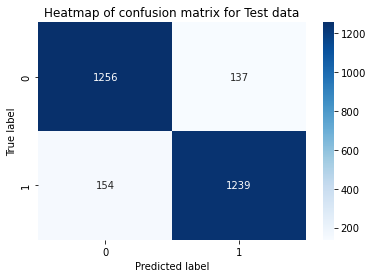

In [19]:
model_lr = LogisticRegression(random_state=42)
model_lr.fit(x_train_wiki, y_train)
predictions = model_lr.predict(x_test_wiki)
evaluate(y_test, predictions )

In [20]:
print(classification_report(y_test, predictions, digits=4))

              precision    recall  f1-score   support

         0.0     0.8908    0.9017    0.8962      1393
         1.0     0.9004    0.8894    0.8949      1393

    accuracy                         0.8955      2786
   macro avg     0.8956    0.8955    0.8955      2786
weighted avg     0.8956    0.8955    0.8955      2786



#### Using **SVM** model with the **default hyperparameters**

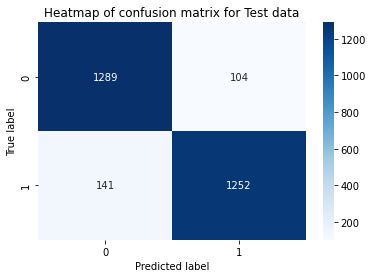

In [21]:
model_svm =svm.SVC(random_state=42)
model_svm.fit(x_train_wiki, y_train)
predictions = model_svm.predict(x_test_wiki)
evaluate(y_test, predictions)

In [22]:
print(classification_report(y_test, predictions, digits=4))

              precision    recall  f1-score   support

         0.0     0.9014    0.9253    0.9132      1393
         1.0     0.9233    0.8988    0.9109      1393

    accuracy                         0.9121      2786
   macro avg     0.9124    0.9121    0.9120      2786
weighted avg     0.9124    0.9121    0.9120      2786



Best C: 2
Best l1_ratio: none
Best solver: lbfgs


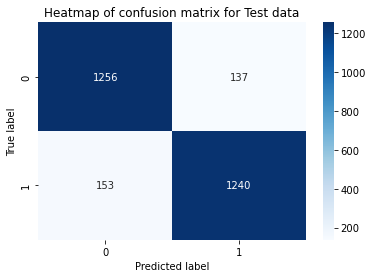

In [23]:
# Hyperparemeter tuning for Logistic Regression model
grid_lr_wiki = {"C":[1, 2, 3, 4], 'l1_ratio':['none', 0, 0.1], 'penalty':['l2', 'elasticnet'],
       'solver':['lbfgs', 'saga']}

model_lr_1000 = LogisticRegression(max_iter=1000, random_state=42)


logreg_cv_glove_wiki=GridSearchCV(model_lr_1000, grid_lr_wiki, n_jobs=-1)
logreg_cv_glove_wiki.fit(x_train_wiki, y_train)

print('Best C:', logreg_cv_glove_wiki.best_estimator_.get_params()['C'])
print('Best l1_ratio:', logreg_cv_glove_wiki.best_estimator_.get_params()['l1_ratio'])
print('Best solver:', logreg_cv_glove_wiki.best_estimator_.get_params()['solver'])

predictions = logreg_cv_glove_wiki.predict(x_test_wiki)
evaluate(y_test, predictions )

In [24]:
print(classification_report(y_test, predictions, digits=4))

              precision    recall  f1-score   support

         0.0     0.8914    0.9017    0.8965      1393
         1.0     0.9005    0.8902    0.8953      1393

    accuracy                         0.8959      2786
   macro avg     0.8960    0.8959    0.8959      2786
weighted avg     0.8960    0.8959    0.8959      2786



Best KERNEL: rbf
Best C: 35


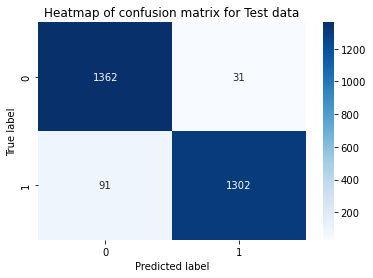

In [25]:
# Hyperparameter tuning for SVM model

grid_svm = [
    {'kernel':('linear', 'rbf')},
    {'C':[1, 5, 11, 15, 19, 23, 27, 31, 35, 39, 43]},
]    

model_svm = svm.SVC(random_state=42)


svm_model_cv_wiki = GridSearchCV(model_svm, grid_svm, n_jobs=-1)

svm_model_cv_wiki.fit(x_train_wiki, y_train)

print('Best KERNEL:', svm_model_cv_wiki.best_estimator_.get_params()['kernel'])
print('Best C:', svm_model_cv_wiki.best_estimator_.get_params()['C'])

predictions = svm_model_cv_wiki.predict(x_test_wiki)
evaluate(y_test, predictions )

In [26]:
print(classification_report(y_test, predictions, digits=4))

              precision    recall  f1-score   support

         0.0     0.9374    0.9777    0.9571      1393
         1.0     0.9767    0.9347    0.9552      1393

    accuracy                         0.9562      2786
   macro avg     0.9571    0.9562    0.9562      2786
weighted avg     0.9571    0.9562    0.9562      2786



### **Conclusions**: 
#### - **All F1 scores** have **high values (above 89.0%)**.
#### - **All tuned** models have **higher values** (some only slightly higher) for **F1 score** than the **corresponding non-tuned** models, as **expected**.
#### - **Comparing** the used metrics regarding pre-trained Glove's word embeddings based on **wikipedia** and on **twitter** datasets, in **this context**, **there aren't noticeable differences**.
#### - The **best F1 scores** were obtained using the **SVM** model with **hyperparameter tuning** (slightly above 95%).